**Important**:
Follow the instructions below when submitting your attempt.
Submissions not following these instructions will not be graded.

1. Submit in **teams of 3 or 4 students**, add their names and matriculation numbers below. Only **one team member should upload** the solutions.
2. **Use jupyter notebook**. Other notebook-editing software (e.g. jupyter-lab, pycharm) might corrupt the notebook files and could have issues with displaying matplotlib interactively.
3. **Do not remove, modify or duplicate** any given cells, except those in which you need to fill in your implementation. You can add new cells in order to present additional texts or plots.
4. **Restart the kernel and re-run the whole notebook** once before submission. After this step, the cell id should be incremental from top to bottom, and all plots should be displayed.
5. **Submit only the `.ipynb` files**, do not upload archives (zip, rar, tar, etc.), images or datasets.
6. **Do not change the filenames** of the `.ipynb` files.

Team members (names and matriculation numbers):
* Fernanda Nader 414400
* Karthika Vijay 417307
* Aditya Krishn 426777
* Supreet Sharma 416613

# Convolutional Neural Networks

In this exercise you will be introduced to some practical aspects of deep learning in computer vision, including constructing a deep neural network and training it via gradient descent to tackle image classification. The PyTorch-framework will be used for this.

We will tackle **image classification** through deep learning methods, in particular we will look at

* Softmax regression with stochastic gradient descent and Adam
* Multilayer perceptrons with tanh and ReLU
* Data augmentation
* A basic convolutional net
* BatchNorm, striding, global average pooling
* Residual networks
* Learning rate decay


### Install PyTorch

Use `conda install -y pytorch torchvision cpuonly -c pytorch` to install PyTorch without GPU support (make sure that the correct conda environment is active). You may also install a GPU-build if you have a compatible GPU, see https://pytorch.org/get-started/locally/. Using a GPU will make the training several times faster, but since not all of you may have one, we have tried to scale this exercise with a CPU in mind.

### TensorBoard Plotting

TensorBoard is a web-based tool for drawing pretty plots of quantities we care about during training, such as the loss. Install it using `conda install -y tensorboard=2.8 -c conda-forge`.

We need to choose a folder where these values will be stored ("logdir"). Start the TensorBoard server by executing e.g. `tensorboard --logdir tensorboard_logs` after you've activated your conda environment. If you change the logdir, also adjust it in the cell below.

You can view the graphs by visiting http://localhost:6006/#custom_scalars in your browser (6006 is the default port).
Make sure that "Custom Scalars" is selected at the top (not "Scalars") because this will give a better visualization.
At first there will be nothing to plot, so it will be empty.

In [2]:
LOG_ROOT = 'tensorboard_logs'
USE_GPU = True  # Set to True if you have installed tensorflow for GPU

In [3]:
%%html
<!-- Run this cell to add heading letters per subtask (like a, b, c) -->
<style>
body {counter-reset: section;}
h2:before {counter-increment: section;
           content: counter(section, lower-alpha) ") ";}
</style>

In [4]:
#%matplotlib inline
import os
import time
import datetime
import numpy as np
import matplotlib.pyplot as plt
import imageio
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter

# Just an image plotting function
def plot_multiple(images, titles=None, colormap='gray',
                  max_columns=np.inf, imwidth=2, imheight=2, share_axes=False):
    """
    Plot multiple images as subplots on a grid. Images must be channel-first
    and between [0, 1].
    """
    images = [np.transpose(im, (1, 2, 0)) for im in images]
    if titles is None:
        titles = [''] * len(images)
    assert len(images) == len(titles)
    n_images = len(images)
    n_cols = min(max_columns, n_images)
    n_rows = int(np.ceil(n_images / n_cols))
    fig, axes = plt.subplots(
        n_rows, n_cols, figsize=(n_cols * imwidth, n_rows * imheight),
        squeeze=False, sharex=share_axes, sharey=share_axes)

    axes = axes.flat
    # Hide subplots without content
    for ax in axes[n_images:]:
        ax.axis('off')
        
    if not isinstance(colormap, (list,tuple)):
        colormaps = [colormap]*n_images
    else:
        colormaps = colormap

    for ax, image, title, cmap in zip(axes, images, titles, colormaps):
        ax.imshow(image, cmap=cmap)
        ax.set_title(title)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
    fig.tight_layout()
    
def visualize_dataset(dataset, n_samples=24, max_columns=6):
    xs, ys = list(zip(*[dataset[i] for i in range(n_samples)]))
    plot_multiple([x / 2 + 0.5 for x in xs], [labels[i] for i in ys], max_columns=max_columns)

## Dataset Preparation
We are going to tackle the classic image classification task using the **CIFAR-10 dataset**, containing 60,000 32x32 RGB images of 10 different classes (50,000 for training and 10,000 for testing). 

![image.png](cifar.png)

The dataset is automatically downloaded if you run the next cell.
It will take some time and might produce quite some output with the default Jupyter settings, but you can ignore this.
After the dataset was downloaded once, this will not happen anymore.
You may read more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html.

Note, that for historical reasons PyTorch uses a "channels-first"-format, i.e. the order of the dimensions for an image is `NCHW` (batch-channels-height-width), not `NHWC` (batch-height-width-channels).

Files already downloaded and verified
Files already downloaded and verified

Shape of an image: torch.Size([3, 32, 32]).


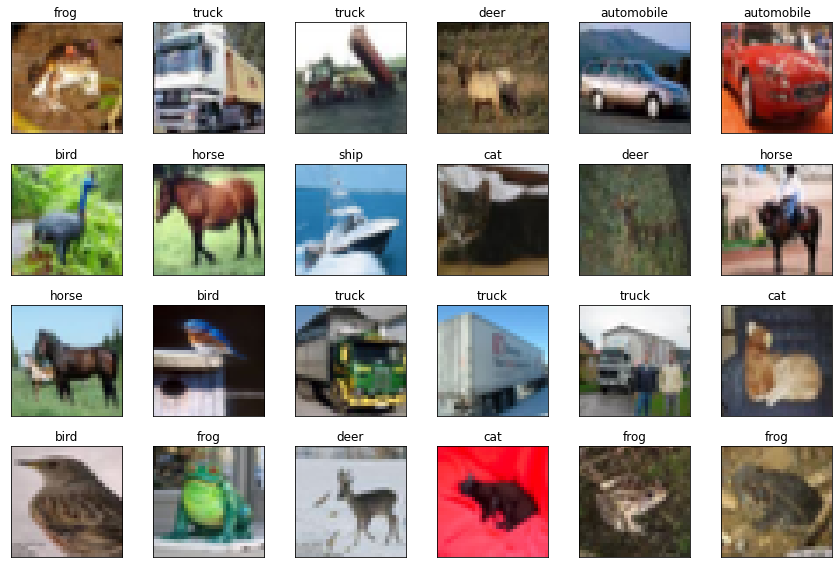

In [5]:
normalize_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

train_data = CIFAR10(root='cifar10/train/', train=True, download=True, transform=normalize_transform)
test_data = CIFAR10(root='cifar10/test/', train=False, download=True, transform=normalize_transform)
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

x, y = train_data[0]  # get an example from the dataset
print(f'\nShape of an image: {x.shape}.')
visualize_dataset(train_data)

## Softmax Regression

Before considering convolutional neural networks, let us start with a simpler classifier called softmax regression (a.k.a. multinomial logistic regression). Note that even though the name contains "regression", this is a classification model.

Softmax regression can be understood as a single-layer neural network. We first flatten our input image to a long vector $\mathbf{x}$, consisting of $32\cdot 32\cdot 3 = 3072$ values. Then we predict class probabilities $\hat{\mathbf{y}}$ through a fully-connected layer with softmax activation:

$$
\mathbf{z} = W \mathbf{x} + \mathbf{b} \\
\hat{y}_c = \operatorname{softmax}(\mathbf{z})_c = \frac{\exp{z_c}}{\sum_{\tilde{c}=1}^{10} \exp{z_{\tilde{c}}}}
$$

Here $z_c$ denotes the $c$th component of the vector $\mathbf{z}$, called the vector of **logits**.
The weights $W$ and biases $\mathbf{b}$ will be learned during training.

### Training

We train the model by minimizing a **loss function** averaged over the training data. As we are tackling a classification problem, the **cross-entropy** is a suitable loss function:

$$
\mathcal{L}_{CE}(\mathbf{y}, \hat{\mathbf{y}}; W, \mathbf{b}) = - \sum_{c=1}^{10} y_c \log{\hat{y}_c}
$$

Note that in the above notation the ground-truth $\mathbf{y}$ is a so-called **one-hot vector**, containing a single 1 component, while the remaining components 
are zeros. The model's predicted $\hat{\mathbf{y}}$ is a vector which also sums to one, but whose components all take continuous values in the range $(0, 1)$.

We minimize the loss by **stochastic gradient descent** (SGD). That is, we repeatedly sample mini-batches from the training data and update the parameters (weights and biases) towards the direction of the steepest decrease of the loss averaged over the mini-batch. For example, the weight $w_{ij}$ (an element of the matrix $W$) is updated according to:

$$
w_{ij}^{(t+1)} = w_{ij}^{(t)} - \eta \cdot \frac{\partial \mathcal{L}_{CE}} {\partial w_{ij}},
$$

with $\eta$ being the learning rate.

----

To build such a model in PyTorch, we take a `Sequential` module which accepts layers that are applied sequentially. Here we have two layers: `Flatten` converts the image into a long vector and `Linear` is a synonym for fully-connected layer. At the end we would expect a `Softmax` layer, but this has to be omitted since the PyTorch-implementation of cross-entropy already performs the softmax implicitly. If you check the equations above, you see why this is advantageous: the cross-entropy applies a $\log$ to the $\exp$ of the softmax, which cancel out. By doing both at once, we avoid unnecessary computations and reduce the risk of numerical issues.

We further define the function `train_classifier` which performs the training process. These are the main steps:

* Instantiate a `DataLoader` for each dataset split which shuffles the order of the data and creates minibatches.
* Instantiate the `CrossEntropyLoss`. Note, that this loss implicitely computes the softmax.
* Iterate over the epochs:
  * Do the training loop:
    * Pass the image batch through the model.
    * Compute the loss.
    * Backpropagate the loss (this computes the gradients for each parameter).
    * Do an optimizer step (this updates the model parameters).
    * Clear the computed gradients.
  * Do a testing loop.
  
During this process, several statistics (loss/accuracy for train/test) are computed, printed and written to TensorBoard. The function also supports specifying a learning rate scheduler, which we will use at the end of this exercise.

In [6]:
def train_classifier(model,
                     opt,
                     logdir,
                     train_data=train_data,
                     test_data=test_data,
                     batch_size=128,
                     n_epochs=50,
                     lr_scheduler=None
                    ):
    
    writer = SummaryWriter(f"{LOG_ROOT}/{logdir}-{time.strftime('%y%m%d_%H%M%S')}")
    layout = {
        'Losses': {'losses': ['Multiline', ['loss/train', 'loss/test']]},
        'Accuracy': {'accuracy': ['Multiline', ['accuracy/train', 'accuracy/test']]}
    }
    writer.add_custom_scalars(layout)
    
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=6)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=6)
    
    criterion = nn.CrossEntropyLoss()
    
    start = time.time()
    
    for epoch in range(n_epochs):
        sample_count = 0
        loss_sum = 0
        correct = 0
        n_batches = len(train_loader)
        model.train()
        for i, (xs, ys) in enumerate(train_loader):
            if USE_GPU:
                xs = xs.cuda()
                ys = ys.cuda()
            out = model(xs)
            loss = criterion(out, ys)
            loss.backward()
            opt.step()
            opt.zero_grad()
            
            loss_sum += loss.item() * xs.shape[0]
            _, pred = torch.max(out, 1)
            correct += (pred == ys).sum().item()
            sample_count += xs.shape[0]
            print(f'Train epoch {epoch+1}, step {i+1}/{n_batches}', end='    \r')

        train_loss = loss_sum / sample_count
        train_accuracy = correct / sample_count
        
        with torch.no_grad():  # do not store gradients during testing, decreases memory consumption
            sample_count = 0
            loss_sum = 0
            correct = 0
            n_batches = len(test_loader)
            model.eval()
            for i, (xs, ys) in enumerate(test_loader):
                if USE_GPU:
                    xs = xs.cuda()
                    ys = ys.cuda()
                out = model(xs)
                loss = criterion(out, ys)
                loss_sum += loss.item() * xs.shape[0]
                _, pred = torch.max(out, 1)
                correct += (pred == ys).sum().item()
                sample_count += xs.shape[0]
                print(f'Test epoch {epoch+1}, step {i+1}/{n_batches}', end='    \r')
                
            test_loss = loss_sum / sample_count
            test_accuracy = correct / sample_count
        
        writer.add_scalar('loss/train', train_loss, epoch+1)
        writer.add_scalar('accuracy/train', train_accuracy, epoch+1)
        writer.add_scalar('loss/test', test_loss, epoch+1)
        writer.add_scalar('accuracy/test', test_accuracy, epoch+1)
            
        if lr_scheduler is not None:
            lr_scheduler.step()
            writer.add_scalar('lr', opt.param_groups[0]['lr'], epoch+1)
            
        print(
            f'Epoch {epoch+1} | train loss: {train_loss:.3f}, train accuracy: {train_accuracy:.3f}, ' + \
            f'test loss: {test_loss:.3f}, test accuracy: {test_accuracy:.3f}, ' + \
            f'time: {str(datetime.timedelta(seconds=int(time.time()-start)))}'
        )

In [69]:
softmax_regression = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features=3072, out_features=10)
)
if USE_GPU:
    softmax_regression.cuda()

opt = optim.SGD(softmax_regression.parameters(), lr=1e-2)
train_classifier(softmax_regression, opt, 'softmax_regression')

Epoch 1 | train loss: 1.872, train accuracy: 0.356, test loss: 1.796, test accuracy: 0.380, time: 0:00:36
Epoch 2 | train loss: 1.779, train accuracy: 0.395, test loss: 1.763, test accuracy: 0.396, time: 0:01:08
Epoch 3 | train loss: 1.750, train accuracy: 0.406, test loss: 1.751, test accuracy: 0.400, time: 0:01:39
Epoch 4 | train loss: 1.732, train accuracy: 0.412, test loss: 1.736, test accuracy: 0.405, time: 0:02:10
Epoch 5 | train loss: 1.718, train accuracy: 0.416, test loss: 1.731, test accuracy: 0.400, time: 0:02:41
Epoch 6 | train loss: 1.709, train accuracy: 0.420, test loss: 1.724, test accuracy: 0.408, time: 0:03:14
Epoch 7 | train loss: 1.701, train accuracy: 0.422, test loss: 1.715, test accuracy: 0.413, time: 0:03:46
Epoch 8 | train loss: 1.694, train accuracy: 0.425, test loss: 1.718, test accuracy: 0.412, time: 0:04:16
Epoch 9 | train loss: 1.688, train accuracy: 0.428, test loss: 1.716, test accuracy: 0.409, time: 0:04:47
Epoch 10 | train loss: 1.684, train accuracy: 

(Jupyter Notebook Tip: you can collapse or hide the output by clicking or double clicking the area directly to the left of the output.)

You can check the how the loss and accuracy (= proportion of correctly predicted classes) change over the course of training in TensorBoard. What do you observe?

*POINTS: 0*

YOUR ANSWER HERE

## Adam Optimizer

There has been a lot of research on improving on the simple stochastic gradient descent algorithm we used above. One of the most popular variants is called **Adam** (https://arxiv.org/abs/1412.6980, "adaptive moment estimation"). Its learning rate usually requires less precise tuning, and something in the range of $(10^{-4},10^{-3})$ often works well in practice. Intuitively, this is because the algorithm automatically adapts the learning rate for each weight depending on the gradients.

You can run it as follows. The difference is not large for such a simple model, but it makes a bigger difference for larger networks.

In [73]:
softmax_regression_adam = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features=3072, out_features=10)
)
if USE_GPU:
    softmax_regression_adam.cuda()
    
opt = optim.Adam(softmax_regression_adam.parameters(), lr=2e-4)
train_classifier(softmax_regression_adam, opt, 'softmax_regression_adam')

Epoch 1 | train loss: 1.859, train accuracy: 0.360, test loss: 1.782, test accuracy: 0.384, time: 0:00:31
Epoch 2 | train loss: 1.767, train accuracy: 0.400, test loss: 1.753, test accuracy: 0.398, time: 0:00:59
Epoch 3 | train loss: 1.740, train accuracy: 0.408, test loss: 1.740, test accuracy: 0.401, time: 0:01:28
Epoch 4 | train loss: 1.723, train accuracy: 0.415, test loss: 1.733, test accuracy: 0.405, time: 0:01:56
Epoch 5 | train loss: 1.711, train accuracy: 0.420, test loss: 1.726, test accuracy: 0.405, time: 0:02:24
Epoch 6 | train loss: 1.700, train accuracy: 0.422, test loss: 1.722, test accuracy: 0.410, time: 0:02:53
Epoch 7 | train loss: 1.693, train accuracy: 0.425, test loss: 1.717, test accuracy: 0.408, time: 0:03:22
Epoch 8 | train loss: 1.687, train accuracy: 0.428, test loss: 1.726, test accuracy: 0.409, time: 0:03:50
Epoch 9 | train loss: 1.681, train accuracy: 0.431, test loss: 1.718, test accuracy: 0.411, time: 0:04:20
Epoch 10 | train loss: 1.677, train accuracy: 

## Interpreting the Learned Weights

Multiplication by the weights $W$ can be interpreted as computing responses to correlation templates per image class.

That means, we can reshape the weight array $W$ to a obtain "template images".

Perform this reshaping to visualize the resulting templates.

torch.Size([10, 3072])


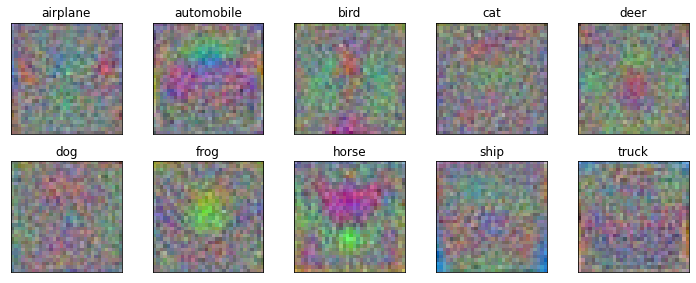

In [74]:
# POINTS: 2

W = softmax_regression[1].weight.data

print(W.shape)
# Use W to create the `templates` variable with dimensions [10 (class count), 3 (rgb), height, width]
# YOUR CODE HERE
templates = W.reshape(10,3,32,32) 

# We normalize the templates for visualization
mini = templates.min()
maxi = templates.max()
rescaled_templates = (templates - mini) / (maxi - mini)
plot_multiple(rescaled_templates.cpu(), labels, max_columns=5)

Do they look as you would expect?

*POINTS: 0*

YOUR ANSWER HERE

## Multi-Layer Perceptron

Softmax regression has a big limitation: the decision surface between any two classes (i.e. the part of the input space where the classification decision changes from one class to another) is a simple hyperplane ("flat").

The **multi-layer perceptron** (MLP) is a neural network model with additional layer(s) between the input and the logits (so-called hidden layers), with nonlinear activation functions. Why are activation functions needed?

Before the current generation of neural networks, the **hyperbolic tangent** (tanh) function used to be the preferred activation function in the hidden layers of MLPs. It is sigmoid shaped and has a range of $(-1,1)$. We can create such a network in PyTorch as follows.

In [75]:
tanh_mlp = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features=3072, out_features=512),
    nn.Tanh(),
    nn.Linear(in_features=512, out_features=10)
)
if USE_GPU:
    tanh_mlp.cuda()
    
opt = optim.Adam(tanh_mlp.parameters(), lr=2e-4)
train_classifier(tanh_mlp, opt, f'tanh_mlp')

Epoch 1 | train loss: 1.780, train accuracy: 0.384, test loss: 1.700, test accuracy: 0.412, time: 0:00:28
Epoch 2 | train loss: 1.642, train accuracy: 0.441, test loss: 1.625, test accuracy: 0.445, time: 0:00:56
Epoch 3 | train loss: 1.563, train accuracy: 0.469, test loss: 1.581, test accuracy: 0.458, time: 0:01:23
Epoch 4 | train loss: 1.500, train accuracy: 0.490, test loss: 1.547, test accuracy: 0.464, time: 0:01:51
Epoch 5 | train loss: 1.442, train accuracy: 0.511, test loss: 1.515, test accuracy: 0.482, time: 0:02:18
Epoch 6 | train loss: 1.387, train accuracy: 0.534, test loss: 1.503, test accuracy: 0.484, time: 0:02:46
Epoch 7 | train loss: 1.339, train accuracy: 0.550, test loss: 1.493, test accuracy: 0.489, time: 0:03:13
Epoch 8 | train loss: 1.286, train accuracy: 0.570, test loss: 1.471, test accuracy: 0.496, time: 0:03:41
Epoch 9 | train loss: 1.238, train accuracy: 0.588, test loss: 1.466, test accuracy: 0.499, time: 0:04:08
Epoch 10 | train loss: 1.191, train accuracy: 

In [17]:
from torchsummary import summary

summary(tanh_mlp, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 3072]               0
            Linear-2                  [-1, 512]       1,573,376
              Tanh-3                  [-1, 512]               0
            Linear-4                   [-1, 10]           5,130
Total params: 1,578,506
Trainable params: 1,578,506
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.03
Params size (MB): 6.02
Estimated Total Size (MB): 6.06
----------------------------------------------------------------


Does it obtain better results than the linear model? What do you observe if you compare the accuracy curves for training and testing?

How and why does the behaviour of the test loss differ from the test accuracy?

*POINTS: 0*

YOUR ANSWER HERE

## Data Augmentation

To avoid this effect, we can use data augmentation. By applying small changes to the training samples, we can virtually increase the size of the dataset such that the model cannot memorize training samples as easily.

Have a look at the `torchvision.transforms` module of torchvision and add the following augmentations below:

* shift the images randomly horizontally and vertically by up to 10% of the height and width
* scale the images randomly between 90% and 110%
* mirror the images such that the right and the left side are swapped in 50% of the cases

Files already downloaded and verified


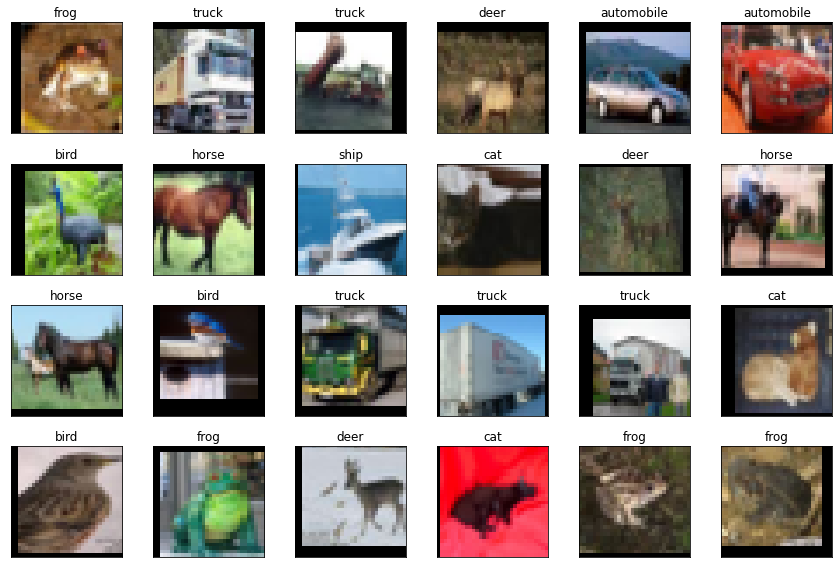

In [8]:
# POINTS: 4

augment_transform = transforms.Compose([
    # YOUR CODE HERE
    transforms.RandomAffine(degrees=0, translate=(.10,.10), scale=(.9,1.1)),
    transforms.RandomHorizontalFlip(p=.5)
])
augmented_train_data = CIFAR10(root='cifar10/train/', train=True, download=True,
                               transform=transforms.Compose([augment_transform, normalize_transform]))
visualize_dataset(augmented_train_data)

In [77]:
tanh_mlp = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features=3072, out_features=512),
    nn.Tanh(),
    nn.Linear(in_features=512, out_features=10)
)
if USE_GPU:
    tanh_mlp.cuda()
    
opt = optim.Adam(tanh_mlp.parameters(), lr=2e-4)
train_classifier(tanh_mlp, opt, f'tanh_mlp_augmented', train_data=augmented_train_data)

Epoch 1 | train loss: 1.874, train accuracy: 0.335, test loss: 1.781, test accuracy: 0.376, time: 0:00:32
Epoch 2 | train loss: 1.748, train accuracy: 0.384, test loss: 1.736, test accuracy: 0.395, time: 0:01:02
Epoch 3 | train loss: 1.685, train accuracy: 0.405, test loss: 1.702, test accuracy: 0.413, time: 0:01:33
Epoch 4 | train loss: 1.635, train accuracy: 0.421, test loss: 1.687, test accuracy: 0.418, time: 0:02:03
Epoch 5 | train loss: 1.599, train accuracy: 0.434, test loss: 1.659, test accuracy: 0.423, time: 0:02:33
Epoch 6 | train loss: 1.570, train accuracy: 0.447, test loss: 1.644, test accuracy: 0.433, time: 0:03:04
Epoch 7 | train loss: 1.544, train accuracy: 0.455, test loss: 1.629, test accuracy: 0.433, time: 0:03:35
Epoch 8 | train loss: 1.524, train accuracy: 0.461, test loss: 1.622, test accuracy: 0.439, time: 0:04:05
Epoch 9 | train loss: 1.503, train accuracy: 0.469, test loss: 1.604, test accuracy: 0.441, time: 0:04:36
Epoch 10 | train loss: 1.484, train accuracy: 

What do you observe if you train the same model on the augmented data?

*POINTS: 0*

YOUR ANSWER HERE

## ReLU

The ReLU activation function has become more popular in recent years, especially for deeper nets. Create and train an MLP with the same architecture as above which uses ReLU instead of tanh as the activation.

In [78]:
# POINTS: 2

relu_mlp = nn.Sequential(
    # YOUR CODE HERE
    nn.Flatten(),
    nn.Linear(in_features=3072, out_features=512),
    nn.ReLU(),
    nn.Linear(in_features=512, out_features=10)
)
if USE_GPU:
    relu_mlp.cuda()

    
opt = optim.Adam(relu_mlp.parameters(), lr=2e-4)
train_classifier(relu_mlp, opt, 'relu_mlp', train_data=augmented_train_data)

Epoch 1 | train loss: 1.791, train accuracy: 0.361, test loss: 1.587, test accuracy: 0.445, time: 0:00:32
Epoch 2 | train loss: 1.630, train accuracy: 0.424, test loss: 1.516, test accuracy: 0.475, time: 0:01:03
Epoch 3 | train loss: 1.566, train accuracy: 0.448, test loss: 1.486, test accuracy: 0.479, time: 0:01:32
Epoch 4 | train loss: 1.524, train accuracy: 0.462, test loss: 1.436, test accuracy: 0.499, time: 0:02:00
Epoch 5 | train loss: 1.493, train accuracy: 0.474, test loss: 1.431, test accuracy: 0.502, time: 0:02:29
Epoch 6 | train loss: 1.472, train accuracy: 0.483, test loss: 1.401, test accuracy: 0.511, time: 0:02:57
Epoch 7 | train loss: 1.452, train accuracy: 0.486, test loss: 1.404, test accuracy: 0.512, time: 0:03:30
Epoch 8 | train loss: 1.436, train accuracy: 0.496, test loss: 1.378, test accuracy: 0.515, time: 0:04:02
Epoch 9 | train loss: 1.422, train accuracy: 0.499, test loss: 1.374, test accuracy: 0.516, time: 0:04:33
Epoch 10 | train loss: 1.408, train accuracy: 

Do the results change? What benefit does ReLU have against tanh?

*POINTS: 0*

YOUR ANSWER HERE

## A Simple Convolutional Neural Network

The previous models did not explicitly make use of the grid structure of the image pixels. Convolutional neural networks do.

Instead of reshaping the input image pixels into one long vector, convolutional layers slide small filters across the input, just as with the convolutional filters we saw earlier in the course. In the earlier parts, we looked at convolution on an image with a single channel in case of grayscale images, or channelwise separate convolutions on RGB images.

In CNNs, the multiple input channels of a conv layer are not handled independently, but are linearly combined. This means that the weight array has shape `[out_channels, in_channels, kernel_height, kernel_width]` and we perform a weighted sum along the input channel axis. Another difference is the use of a **bias** vector of shape `[out_channels]`, each components gets added to the corresponding output channel.

As you already know, convolution is a linear operator, so it is possible to express any convolutional layer as a fully-connected layer.
However, the convolutional layer's weight matrix is sparse (has many zeros) compared to a fully-connected ("linear") layer because each output only depends on a small number of inputs, namely, those within a small neigborhood. Further, the weight values are shared between the different pixel locations.

This tutorial has some great visualisations and explanations on the details of conv layers: https://arxiv.org/abs/1603.07285.

Technically, what's called a "convolutional" layer is usually implemented as a *cross-correlation* computation. Could there be any advantage in using the actual definition of convolution in these layers?

*POINTS: 0*

YOUR ANSWER HERE

Train the following simple CNN model. It may take about 30 minutes on a CPU.

In [79]:
cnn = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(in_features=4096, out_features=10)
)
if USE_GPU:
    cnn.cuda()

opt = optim.Adam(cnn.parameters(), lr=1e-3)
train_classifier(cnn, opt, 'cnn', train_data=augmented_train_data)

Epoch 1 | train loss: 1.557, train accuracy: 0.440, test loss: 1.230, test accuracy: 0.561, time: 0:00:33
Epoch 2 | train loss: 1.234, train accuracy: 0.562, test loss: 1.038, test accuracy: 0.635, time: 0:01:05
Epoch 3 | train loss: 1.102, train accuracy: 0.612, test loss: 0.944, test accuracy: 0.673, time: 0:01:36
Epoch 4 | train loss: 1.028, train accuracy: 0.643, test loss: 0.918, test accuracy: 0.679, time: 0:02:07
Epoch 5 | train loss: 0.977, train accuracy: 0.661, test loss: 0.898, test accuracy: 0.691, time: 0:02:38
Epoch 6 | train loss: 0.949, train accuracy: 0.671, test loss: 0.834, test accuracy: 0.715, time: 0:03:09
Epoch 7 | train loss: 0.913, train accuracy: 0.684, test loss: 0.820, test accuracy: 0.718, time: 0:03:41
Epoch 8 | train loss: 0.896, train accuracy: 0.691, test loss: 0.835, test accuracy: 0.709, time: 0:04:12
Epoch 9 | train loss: 0.869, train accuracy: 0.698, test loss: 0.835, test accuracy: 0.722, time: 0:04:44
Epoch 10 | train loss: 0.858, train accuracy: 

In [20]:
from torchsummary import summary

summary(cnn, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
         MaxPool2d-3           [-1, 64, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          36,928
              ReLU-5           [-1, 64, 16, 16]               0
         MaxPool2d-6             [-1, 64, 8, 8]               0
           Flatten-7                 [-1, 4096]               0
            Linear-8                   [-1, 10]          40,970
Total params: 79,690
Trainable params: 79,690
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 1.44
Params size (MB): 0.30
Estimated Total Size (MB): 1.75
----------------------------------------------------------------


Does it improve the result? Does it run faster than the MLP?

*POINTS: 0*

YOUR ANSWER HERE

How many parameters does this model have? How many parameters has the MLP? Show the steps of your computation!

*POINTS: 0*

YOUR ANSWER HERE

## Implementing the Forward Pass

To confirm your understanding of the main CNN components, implement the forward pass of the convolutional, max pooling and dense layers, plus the relu activation function. For simplicity, assume a fixed filter size of 3x3 for the convolution, with stride 1 and use zero padding, such that the spatial size does not change (called 'same' padding). Implement this in `conv3x3_same`. For max pooling assume a fixed 2x2 pooling size and stride 2 in `maxpool2x2`.

To check whether your implementation is correct, we can extract the weights from the PyTorch model we trained above, and feed these weights and an test input to your implementation of the forward pass. If your result disagrees with PyTorch, there is probably a bug somewhere!

In [80]:
# POINTS: 10

def conv3x3_same(x, weights, biases):
    """Convolutional layer with filter size 3x3 and 'same' padding.
    `x` is a NumPy array of shape [in_channels, height, width]
    `weights` has shape [out_channels, in_channels, kernel_height, kernel_width]
    `biases` has shape [out_channels]
    Return the output of the 3x3 conv (without activation)
    """
    # YOUR CODE HERE
    result = np.zeros((weights.shape[0], x.shape[1],x.shape[2]))
    x = np.pad(x, [(0,0),(1,1),(1,1)])
    for i in range(0, x.shape[1]-3+1):
        for j in range(0, x.shape[2]-3+1):
            for k in range(weights.shape[0]):
                result[k,i,j] = np.sum(x[:,i:i+3,j:j+3]*weights[k,...])

    biases = biases.reshape(biases.shape[0],1,1)
    result += biases

    return result

def maxpool2x2(x):
    """Max pooling with pool size 2x2 and stride 2.
    `x` is a numpy array of shape [in_channels, height, width]
    """
    # YOUR CODE HERE
    result = np.zeros((x.shape[0], x.shape[1]//2,x.shape[2]//2))
    for i in range(0, result.shape[1]):
        for j in range(0, result.shape[2]):
                result[...,i,j] = np.max(x[:,i*2:i*2+2,j*2:j*2+2], axis=(1,2))
    return result

def linear(x, weights, biases):
    # YOUR CODE HERE
    return x@weights.T + biases
    
def relu(x):
    # YOUR CODE HERE
    return np.maximum(0,x)

def my_predict_cnn(x, W1, b1, W2, b2, W3, b3):
    x = conv3x3_same(x, W1, b1)
    x = relu(x)
    x = maxpool2x2(x)
    x = conv3x3_same(x, W2, b2)
    x = relu(x)
    x = maxpool2x2(x)
    x = x.reshape(-1)
    x = linear(x, W3, b3)
    return x

W1 = cnn[0].weight.data.cpu().numpy()
b1 = cnn[0].bias.data.cpu().numpy()
W2 = cnn[3].weight.data.cpu().numpy()
b2 = cnn[3].bias.data.cpu().numpy()
W3 = cnn[7].weight.data.cpu().numpy()
b3 = cnn[7].bias.data.cpu().numpy()

inp = train_data[0][0]
inp_np = inp.numpy()
if USE_GPU:
    inp = inp.cuda()
my_logits = my_predict_cnn(inp_np, W1, b1, W2, b2, W3, b3)
pytorch_logits = cnn(inp[np.newaxis])[0]
if np.mean((my_logits-pytorch_logits.detach().cpu().numpy())**2) > 1e-5:
    print('Something isn\'t right! PyTorch gives different results than my_predict_cnn!')
else:
    print('Congratulations, you got correct results!')

Congratulations, you got correct results!


## Batch Normalization

Batch normalization is a modern technique to improve and speed up the training of deep neural networks (BatchNorm, Ioffe & Szegedy ICML'15, https://arxiv.org/abs/1502.03167). Each feature channel is normalized to have zero mean and unit variance across the spatial and mini-batch axes. To compensate for the lost degrees of freedom, extra scaling and bias parameters are introduced and learned. Mathematically, BatchNorm for a spatial feature map (e.g. the output of conv) can be written as:

$$
\mu_d = \mathbb{E}\{x_{\cdot \cdot d}\}, \\
\sigma_d = \sqrt{\operatorname{Var}\{x_{\cdot \cdot d}\}} \\
z_{ijd} = \gamma_d \cdot \frac{x_{ijd} - \mu_d}{\sigma_d} + \beta_d,\\
$$

with the expectation and variance taken across both the data samples of the batch and the spatial dimensions.

The $\mu_d$ and $\sigma_d$ values are computed on the actual mini-batch during training, but at test-time they are fixed, so that the prediction of the final system on a given sample does not depend on other samples in the mini-batch. To obtain the fixed values for test-time use, one needs to maintain moving statistics over the activations during training. This can be a bit tricky to implement from scratch, but luckily this is now implemented in all popular frameworks, including PyTorch.

When applying BatchNorm, it is not necessary to use biases in the previous convolutional layer. Why? Use the `bias` argument of `nn.Conv2d` accordingly.

*POINTS: 0*

YOUR ANSWER HERE

Create a modified version of the previous model using batch normalization between each convolution and the corresponding activation.

In [81]:
# POINTS: 3

cnn_batchnorm = nn.Sequential(
    # YOUR CODE HERE
    nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1, bias=True),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, bias=True),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(in_features=4096, out_features=10)
)
if USE_GPU:
    cnn_batchnorm.cuda()

opt = optim.Adam(cnn_batchnorm.parameters(), lr=1e-3)
train_classifier(cnn_batchnorm, opt, 'cnn_batchnorm', train_data=augmented_train_data)

Epoch 1 | train loss: 1.420, train accuracy: 0.509, test loss: 1.100, test accuracy: 0.620, time: 0:00:33
Epoch 2 | train loss: 1.126, train accuracy: 0.611, test loss: 0.929, test accuracy: 0.685, time: 0:01:06
Epoch 3 | train loss: 1.019, train accuracy: 0.648, test loss: 0.886, test accuracy: 0.697, time: 0:01:38
Epoch 4 | train loss: 0.953, train accuracy: 0.672, test loss: 0.853, test accuracy: 0.705, time: 0:02:09
Epoch 5 | train loss: 0.904, train accuracy: 0.689, test loss: 0.804, test accuracy: 0.725, time: 0:02:42
Epoch 6 | train loss: 0.872, train accuracy: 0.699, test loss: 0.802, test accuracy: 0.722, time: 0:03:13
Epoch 7 | train loss: 0.839, train accuracy: 0.709, test loss: 0.768, test accuracy: 0.739, time: 0:03:45
Epoch 8 | train loss: 0.813, train accuracy: 0.720, test loss: 0.766, test accuracy: 0.740, time: 0:04:18
Epoch 9 | train loss: 0.796, train accuracy: 0.727, test loss: 0.743, test accuracy: 0.746, time: 0:04:50
Epoch 10 | train loss: 0.780, train accuracy: 

## Strided Convolutions

Max-pooling is a popular technique for reducing the spatial dimensionality
of the outputs from conv layers. Another way to reduce dimensionality is striding. For an argument why this may be similarly effective, see [Springenberg et al., ICLRW'15](https://arxiv.org/pdf/1412.6806.pdf).

Now create a model using the same architecture as before, with the difference of
removing the max-pooling layers and increasing the stride parameter of the conv layers to $2 \times 2$ in the spatial dimensions. 

In [82]:
# POINTS: 2

cnn_strides = nn.Sequential(
    # YOUR CODE HERE
    nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1, bias=True, stride=2),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, bias=True, stride=2),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=4096, out_features=10)
)
if USE_GPU:
    cnn_strides.cuda()

opt = optim.Adam(cnn_strides.parameters(), lr=1e-3)
train_classifier(cnn_strides, opt, 'cnn_strides', train_data=augmented_train_data)

Epoch 1 | train loss: 1.525, train accuracy: 0.452, test loss: 1.187, test accuracy: 0.570, time: 0:00:38
Epoch 2 | train loss: 1.256, train accuracy: 0.551, test loss: 1.096, test accuracy: 0.609, time: 0:01:11
Epoch 3 | train loss: 1.143, train accuracy: 0.596, test loss: 1.019, test accuracy: 0.641, time: 0:01:44
Epoch 4 | train loss: 1.073, train accuracy: 0.621, test loss: 0.993, test accuracy: 0.651, time: 0:02:17
Epoch 5 | train loss: 1.031, train accuracy: 0.640, test loss: 0.922, test accuracy: 0.677, time: 0:02:49
Epoch 6 | train loss: 0.995, train accuracy: 0.650, test loss: 0.871, test accuracy: 0.700, time: 0:03:22
Epoch 7 | train loss: 0.973, train accuracy: 0.660, test loss: 0.875, test accuracy: 0.692, time: 0:03:54
Epoch 8 | train loss: 0.946, train accuracy: 0.670, test loss: 0.934, test accuracy: 0.669, time: 0:04:27
Epoch 9 | train loss: 0.934, train accuracy: 0.673, test loss: 0.861, test accuracy: 0.705, time: 0:04:59
Epoch 10 | train loss: 0.908, train accuracy: 

What differences do you notice when training this new network?
What is a clear advantage of using strides?

*POINTS: 0*

YOUR ANSWER HERE

## Global Pooling

The above network ends in a `Flatten` layer followed by a `Linear` layer, in which the number of weights depends on the input size. This means that testing can only be performed on the exact same image size. Several architectures employ a (spatial) **global average pooling layer** to produce a vector of fixed size describing the whole image.

Implement the forward pass of such a layer below. The input `x` has size `[batch_size, channels, height, width]`. The mean must be computed across the last two dimensions, such that the result `pooled` has a size of `[batch_size, channels]`. Note, that you cannot use numpy for this as PyTorch is not able to backpropagate through numpy functions. There are however corresponding PyTorch functions for almost all numpy functions.

This layer can now replace the flattening operation from the previous network. However, the units before the average pooling need to have a large enough receptive field, otherwise the model will not work well. Therefore, compared with the previous model, remove the `Flatten` layer and instead add a third Conv-BatchNorm-ReLU combination. Then add `GlobalAvgPool2d` and a final `Linear` layer which returns $10$ values per sample instead of $64$.

Train it and see if it reaches similar accuracy to the previous one.

In [9]:
# POINTS: 4

class GlobalAvgPool2d(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        # YOUR CODE HERE
        return torch.mean(input=x, dim=(2,3))


cnn_global_pool = nn.Sequential(
    # YOUR CODE HERE
    nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1, bias=True, stride=2),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, bias=True, stride=2),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, bias=True, stride=2),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    GlobalAvgPool2d(),
    nn.Linear(in_features=64, out_features=10)
)
if USE_GPU:
    cnn_global_pool.cuda()

opt = optim.Adam(cnn_global_pool.parameters(), lr=1e-3)
train_classifier(cnn_global_pool, opt, 'cnn_global_pool', train_data=augmented_train_data)

c:\Users\Supreet\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\utils\data\dataloader.py:487: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 1 | train loss: 1.645, train accuracy: 0.401, test loss: 1.522, test accuracy: 0.454, time: 0:00:44
Epoch 2 | train loss: 1.350, train accuracy: 0.514, test loss: 1.312, test accuracy: 0.522, time: 0:01:14
Epoch 3 | train loss: 1.241, train accuracy: 0.556, test loss: 1.269, test accuracy: 0.533, time: 0:01:47
Epoch 4 | train loss: 1.171, train accuracy: 0.582, test loss: 1.159, test accuracy: 0.577, time: 0:02:23
Epoch 5 | train loss: 1.126, train accuracy: 0.600, test loss: 1.145, test accuracy: 0.595, time: 0:02:55
Epoch 6 | train loss: 1.088, train accuracy: 0.613, test loss: 1.082, test accuracy: 0.617, time: 0:03:27
Epoch 7 | train loss: 1.054, train accuracy: 0.628, test loss: 1.082, test accuracy: 0.615, time: 0:03:59
Epoch 8 | train loss: 1.027, train accuracy: 0.637, test loss: 1.045, test accuracy: 0.636, time: 0:04:31
Epoch 9 | train loss: 1.003, train accuracy: 0.646, test loss: 1.033, test accuracy: 0.637, time: 0:05:08
Epoch 10 | train loss: 0.982, train accuracy: 

In [21]:
summary(cnn_global_pool, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           1,792
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
            Conv2d-4             [-1, 64, 8, 8]          36,928
       BatchNorm2d-5             [-1, 64, 8, 8]             128
              ReLU-6             [-1, 64, 8, 8]               0
            Conv2d-7             [-1, 64, 4, 4]          36,928
       BatchNorm2d-8             [-1, 64, 4, 4]             128
              ReLU-9             [-1, 64, 4, 4]               0
  GlobalAvgPool2d-10                   [-1, 64]               0
           Linear-11                   [-1, 10]             650
Total params: 76,682
Trainable params: 76,682
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/ba

Which network has more parameters, this or the previous one?

What is the size of the receptive field of the units in the layer directly before the global average pooling? (Remember: the receptive field of a particular unit (neuron) is the area of the *input image* that can influence the activation of this given unit).

*POINTS: 0*

YOUR ANSWER HERE

## Residual Networks

ResNet is a more modern architecture, introduced by He et al. in 2015 (published in 2016: https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf) and is still popular today.

It consists of blocks like the following:

![ResNet Block](resnet_block.png)

Each of these so-called *residual blocks* only have to predict a *residual* (in plain words: the "rest", the "leftover") that will be added on top of its input.
In other words, the block outputs how much each feature needs to be changed in order to enhance the representation compared to the previous block.

There are several ways to combine residual blocks into *residual networks* (ResNets). In the following, we consider ResNet-v1, as used for the CIFAR-10 benchmark in the original ResNet paper (it is simpler compared to the full model that they used for the much larger ImageNet benchmark).

Section 4.2. of the paper describes this architecture as follows: "*The first layer is 3×3 convolutions. Then we use a stack of 6n layers with 3×3 convolutions on the feature maps of sizes {32, 16, 8} respectively, with 2n layers for each feature map size. The numbers of filters are {16, 32, 64} respectively. The subsampling is performed by convolutions with a stride of 2. The network ends with a global average pooling, a 10-way fully-connected layer, and softmax. [...] When shortcut connections are used, they are connected to the pairs of 3×3 layers (totally 3n shortcuts). On this dataset we use identity shortcuts in all cases.*"

Further, they use L2 regularization for training (a standard tool to combat overfitting). This penalizes weights with large magnitude by adding an additional term to the cost function, besides the cross-entropy. The overall function to optimize becomes:

$$
\mathcal{L}_{CE} + \frac{\lambda}{2} \sum_{w\in\text{weights}} w^2,
$$

and in this paper $\lambda=10^{-4}$.

Use the explanation above to complete the `layers`-list in the `ResNet`-class below. Note, that the first layer is already added and remember that the final softmax has to be omitted. The `ResNetBlock` already implements the above figure, i.e. contains $2$ convolutions.

Weight decay is already added by setting the corresponding attribute of the opimizer.

In [10]:
# POINTS: 6

class ResNetBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.f = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        self.activation = nn.ReLU()
        # The shortcut connection is just the identity. If feature
        # channel counts differ between input and output, zero
        # padding is used to match the depths. This is implemented
        # by a convolution with the following fixed weight:
        self.pad_weight = nn.Parameter(
            torch.eye(out_channels, in_channels)[:, :, None, None],
            requires_grad=False
        )
        self.stride = stride

    def forward(self, x):
        r = self.f(x)
        # We apply the padding weight using torch.functional.conv2d
        # which allows us to use a custom weight matrix.
        x = F.conv2d(x, self.pad_weight, stride=self.stride)
        return self.activation(x + r)
    

class ResNet(torch.nn.Module):
    def __init__(self, num_layers=14, in_channels=3, out_features=10):
        super().__init__()
        if (num_layers - 2) % 6 != 0:
            raise ValueError('n_layers should be 6n+2 (eg 20, 32, 44, 56)')
        n = (num_layers - 2) // 6
        
        layers = []
        
        first_layer = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        
        layers.append(first_layer)

        # YOUR CODE HERE
        num_filter = 16
        for group in range(3):
            for block in range(n):
                if group >0 and block==0:
                    num_filter *= 2
                    layers.append(ResNetBlock(num_filter//2,num_filter,stride=2))
                layers.append(ResNetBlock(num_filter,num_filter,stride=2))
        
        layers.append(GlobalAvgPool2d())
        layers.append(nn.Linear(in_features=64, out_features=10))
            
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

Train ResNet-18 on the CIFAR-10 dataset for 50 epochs. As a rough idea, it will take less than 15 minutes with a good GPU, but on a CPU it can take several hours.

In [11]:
resnet = ResNet()
if USE_GPU:
    resnet.cuda()

opt = optim.Adam(resnet.parameters(), lr=1e-3, weight_decay=1e-4)
train_classifier(resnet, opt, f'resnet', train_data=augmented_train_data)

Epoch 1 | train loss: 1.749, train accuracy: 0.355, test loss: 1.468, test accuracy: 0.459, time: 0:00:41
Epoch 2 | train loss: 1.426, train accuracy: 0.477, test loss: 1.325, test accuracy: 0.518, time: 0:01:20
Epoch 3 | train loss: 1.300, train accuracy: 0.528, test loss: 1.193, test accuracy: 0.566, time: 0:01:57
Epoch 4 | train loss: 1.203, train accuracy: 0.566, test loss: 1.150, test accuracy: 0.587, time: 0:02:33
Epoch 5 | train loss: 1.110, train accuracy: 0.602, test loss: 1.083, test accuracy: 0.612, time: 0:03:12
Epoch 6 | train loss: 1.050, train accuracy: 0.623, test loss: 1.054, test accuracy: 0.628, time: 0:03:49
Epoch 7 | train loss: 1.005, train accuracy: 0.642, test loss: 0.916, test accuracy: 0.678, time: 0:04:28
Epoch 8 | train loss: 0.963, train accuracy: 0.656, test loss: 0.901, test accuracy: 0.682, time: 0:05:06
Epoch 9 | train loss: 0.933, train accuracy: 0.666, test loss: 0.887, test accuracy: 0.686, time: 0:05:44
Epoch 10 | train loss: 0.901, train accuracy: 

## Learning Rate Decay

Learning rate decay reduces the learning rate as the training progresses. Use the same settings as in the previous experiment, but this time create a `MultiStepLR`-scheduler and decrease the learning rate twice by a factor of 10 each.

In [22]:
# POINTS: 2
from torch.optim.lr_scheduler import MultiStepLR

resnet_decay = ResNet()
if USE_GPU:
    resnet_decay.cuda()

opt = optim.Adam(resnet_decay.parameters(), lr=1e-3, weight_decay=1e-4)
# YOUR CODE HERE
scheduler = MultiStepLR(opt, milestones=[10,20,30,40], gamma=0.5)

train_classifier(resnet_decay, opt, 'resnet_decay', lr_scheduler=scheduler, train_data=augmented_train_data)

c:\Users\Supreet\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\utils\data\dataloader.py:487: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 1 | train loss: 1.737, train accuracy: 0.352, test loss: 1.432, test accuracy: 0.468, time: 0:00:40
Epoch 2 | train loss: 1.418, train accuracy: 0.478, test loss: 1.258, test accuracy: 0.544, time: 0:01:23
Epoch 3 | train loss: 1.284, train accuracy: 0.535, test loss: 1.154, test accuracy: 0.581, time: 0:01:58
Epoch 4 | train loss: 1.185, train accuracy: 0.574, test loss: 1.124, test accuracy: 0.597, time: 0:02:39
Epoch 5 | train loss: 1.094, train accuracy: 0.609, test loss: 1.008, test accuracy: 0.641, time: 0:03:18
Epoch 6 | train loss: 1.032, train accuracy: 0.634, test loss: 0.949, test accuracy: 0.659, time: 0:03:57
Epoch 7 | train loss: 0.972, train accuracy: 0.655, test loss: 0.946, test accuracy: 0.668, time: 0:04:35
Epoch 8 | train loss: 0.931, train accuracy: 0.670, test loss: 0.904, test accuracy: 0.679, time: 0:05:11
Epoch 9 | train loss: 0.903, train accuracy: 0.681, test loss: 0.848, test accuracy: 0.708, time: 0:05:50
Epoch 10 | train loss: 0.871, train accuracy: 